In [3]:
%matplotlib notebook
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pygalmesh
import meshio
from mpi4py import MPI
import fenics as fe
import fenics_adjoint as fa
import torch
import torch.nn.functional as F
import torch_fenics

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys
sys.path.append('..')
import project

# Load lung CT image data

In [5]:
case_name = 'Case1Pack'
ee_phase = 50
ei_phase = 0
lung_roi = 'lung_combined_mask'

In [6]:
ds = project.imaging.Emory4DCTDataset(
    data_root='../data/Emory-4DCT',
    case_names=[case_name],
    phases=[ei_phase, ee_phase]
)
ds.load_niftis()
ds.load_masks(roi=['lung_combined_mask', 'body'])
ds.load_displacements(fixed_phase=ee_phase)

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T00_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T50.nii.gz


In [7]:
case = ds[0]

ee_anat_image = case.array.sel(phase=ee_phase)
ei_anat_image = case.array.sel(phase=ei_phase)

ee_lung_mask = case.mask.sel(phase=ee_phase, roi=lung_roi)
ei_lung_mask = case.mask.sel(phase=ei_phase, roi=lung_roi)

ee_overlay = (ee_lung_mask + 1) / 2
ei_overlay = (ei_lung_mask + 1) / 2

reg_disp_image = case.disp.sel(phase=0)

<IPython.core.display.Javascript object>


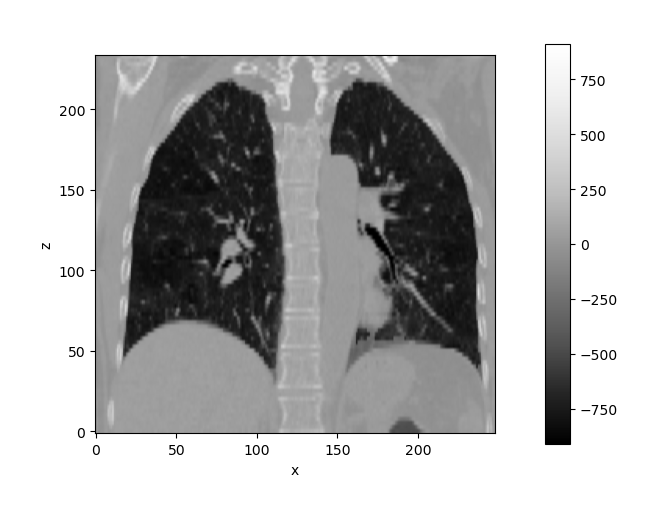

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


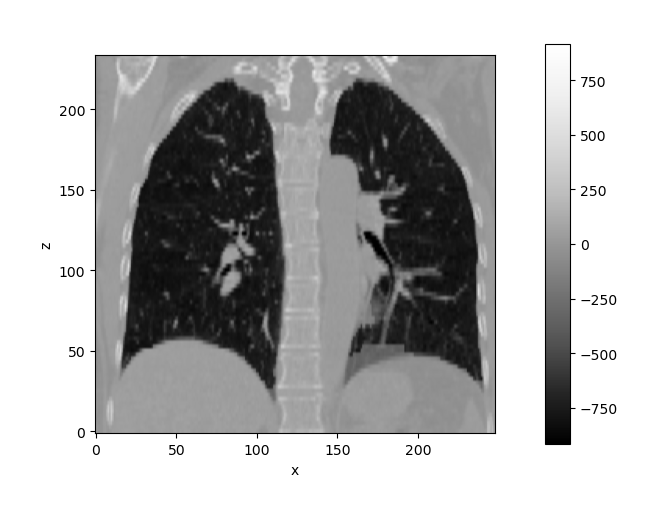

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


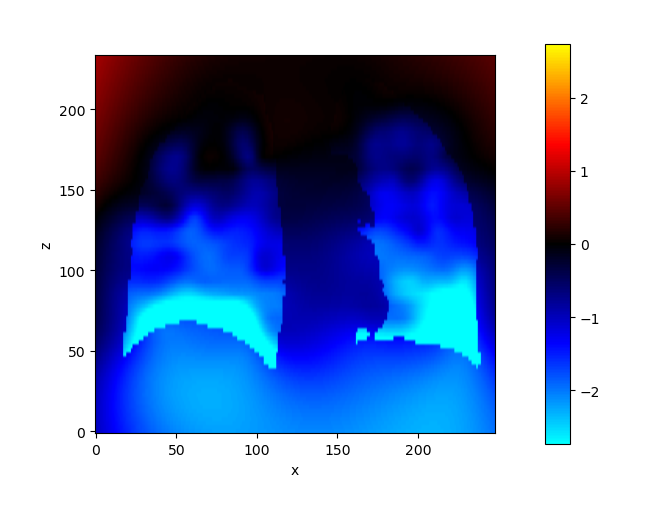

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [11]:
project.visual.view(ee_anat_image * ee_overlay, x='x', y='z', cmap='Greys_r').update_index(y=140)
project.visual.view(ei_anat_image * ei_overlay, x='x', y='z', cmap='Greys_r').update_index(y=140)
project.visual.view(reg_disp_image * ee_overlay, x='x', y='z').update_index(y=140, component=2)

In [ ]:
# direct inversion

dx_image = reg_disp_image.differentiate('x')
dy_image = reg_disp_image.differentiate('y')
dz_image = reg_disp_image.differentiate('z')

dxx_image = dx_image.differentiate('x')
dyy_image = dy_image.differentiate('y')
dzz_image = dz_image.differentiate('z')

laplacian_image = dxx_image + dyy_image + dzz_image

rho = 1000
omega = 2 * np.pi * 1
elast_image = -rho * omega**2 * (reg_disp_image.sum('component') / laplacian_image.sum('component'))
elast_image.name = 'elasticity'

project.visual.view(np.abs(elast_image) * ee_overlay, x='x', y='z', cmap=project.visual.mre_color_map())

# Anatomical mesh generation

In [54]:
%%time
ee_lung_mesh = pygalmesh.generate_from_array(
    ee_lung_mask.values.astype(np.uint16),
    voxel_size=case.resolution,
    max_cell_circumradius=5.0,
    odt=True
)
ee_lung_mesh

CPU times: user 5.1 s, sys: 25.7 ms, total: 5.13 s
Wall time: 5.16 s


<meshio mesh object>
  Number of points: 14068
  Number of cells:
    triangle: 19468
    tetra: 69594
  Point data: medit:ref
  Cell data: medit:ref

In [55]:
def check_used_points(mesh):
    point_inds = np.arange(mesh.points.shape[0])
    point_used = np.zeros_like(point_inds, dtype=bool)
    for cells in mesh.cells:
        used_in_cells = np.unique(cells.data)
        point_used |= np.isin(point_inds, used_in_cells)
        
    return point_used

np.flatnonzero(~check_used_points(ee_lung_mesh))

array([861, 893])

In [56]:
def remove_unused_points(mesh):

    points = mesh.points
    tri_cells = mesh.cells[0].data
    tet_cells = mesh.cells[1].data
    
    # identify the used points
    points_used = np.unique(np.concatenate([
        tri_cells.flatten(), tet_cells.flatten()
    ]))
    
    # mapping from old indices to new indices
    new_indices = np.zeros(points.shape[0], dtype=int)
    new_indices[points_used] = np.arange(len(points_used))
    
    # filter points to keep only the used points
    new_points = points[points_used]
    
    # update the cell indices
    new_tri_cells = new_indices[tri_cells]
    new_tet_cells = new_indices[tet_cells]
    
    return meshio.Mesh(
        new_points, [('triangle', new_tri_cells), ('tetra', new_tet_cells)]
    )

np.flatnonzero(~check_used_points(remove_unused_points(ee_lung_mesh)))

array([], dtype=int64)

In [57]:
ee_lung_mesh = remove_unused_points(ee_lung_mesh)
ee_lung_mesh

<meshio mesh object>
  Number of points: 14066
  Number of cells:
    triangle: 19468
    tetra: 69594

In [58]:
%%time
vertices = ee_lung_mesh.points
facets = ee_lung_mesh.cells[0].data
tetras = ee_lung_mesh.cells[1].data

tetra_facets = np.concatenate([
    tetras[:,[0,1,2]],
    tetras[:,[0,1,3]],
    tetras[:,[0,2,3]],
    tetras[:,[1,2,3]],
    
    tetras[:,[2,1,0]],
    tetras[:,[3,1,0]],
    tetras[:,[3,2,0]],
    tetras[:,[3,2,1]],
])

#angles = project.meshing.compute_angles_to_interior(vertices, facets, tetras)
#tetra_angles = project.meshing.compute_angles_to_interior(vertices, tetra_facets, tetras)

vertices.shape, facets.shape, tetras.shape

CPU times: user 4.59 ms, sys: 2.04 ms, total: 6.62 ms
Wall time: 5.36 ms


((14066, 3), (19468, 3), (69594, 4))

<IPython.core.display.Javascript object>


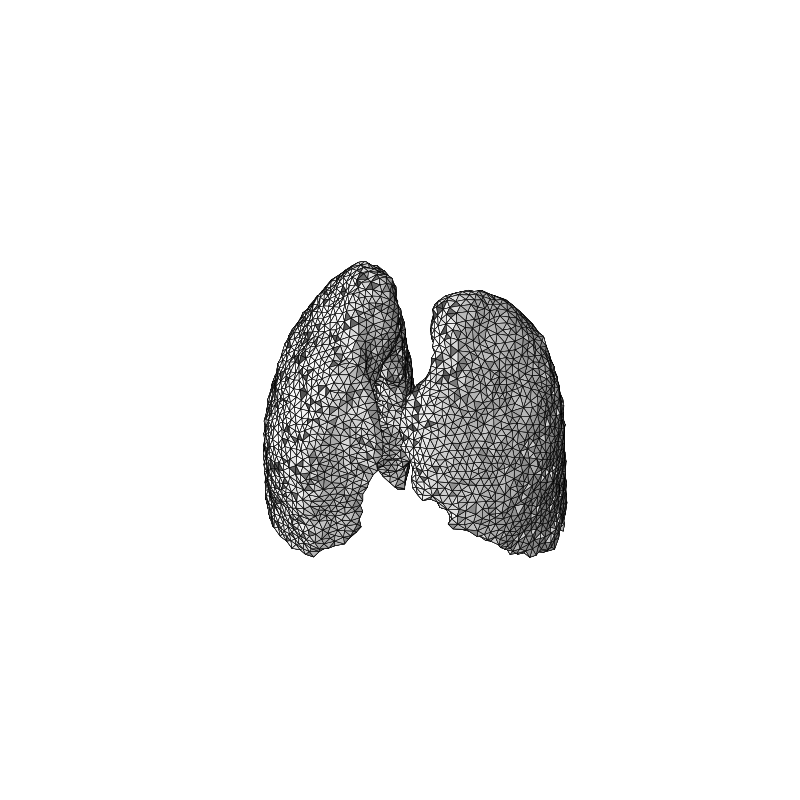

In [59]:
# view surface mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    facets, #[angles > 0],
    facecolors='white',
    edgecolors='black',
    shade=True,
    alpha=1.0,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

<IPython.core.display.Javascript object>


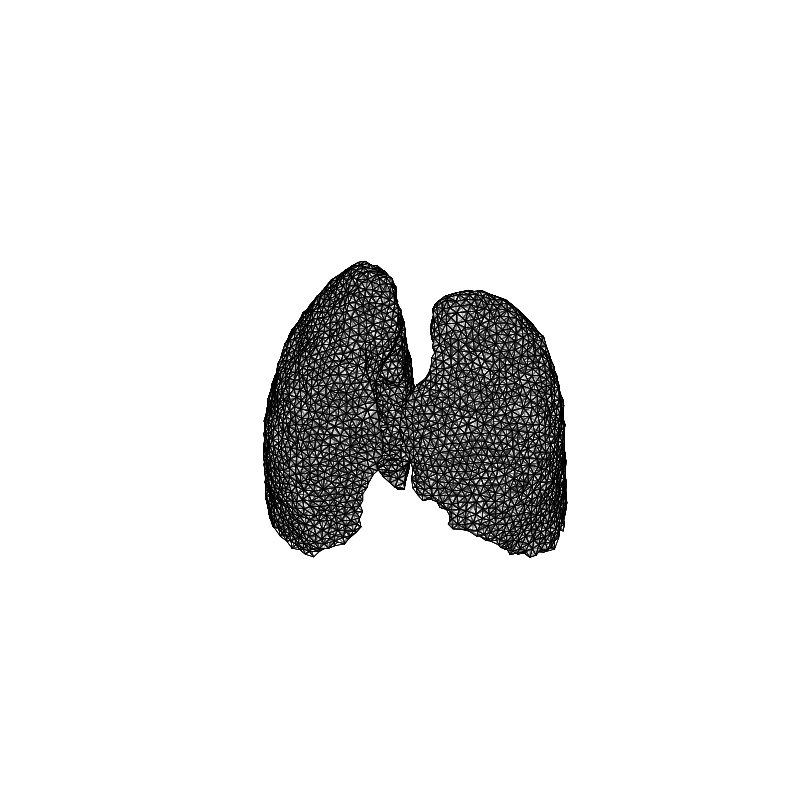

In [60]:
# view volume mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    tetra_facets,
    facecolors='white',
    edgecolors='black',
    alpha=0.1,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

In [61]:
def convert_to_fe_mesh(points, cells):
    '''
    Convert from meshio to fenics mesh.
    '''
    mesh_file = 'temp.xdmf'
    meshio.write_points_cells(mesh_file, points, [(cells.type, cells.data)])
    fe_mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, mesh_file) as f:
        f.read(fe_mesh)
    return fe_mesh

ee_lung_fe_mesh = convert_to_fe_mesh(ee_lung_mesh.points, ee_lung_mesh.cells[1])
ee_lung_fe_mesh

In [62]:
%%time
u_tensor = torch.as_tensor(reg_disp_image.values)
print(u_tensor.shape)

u_func_space = fe.VectorFunctionSpace(ee_lung_fe_mesh, 'P', 1)
u_func_dofs = project.interpolate.image_to_dofs(u_tensor, case.resolution, u_func_space)
print(u_func_dofs.shape)

torch.Size([256, 256, 94, 3])
torch.Size([14066, 3])
CPU times: user 710 ms, sys: 50.8 ms, total: 761 ms
Wall time: 2.59 s


In [63]:
%%time
u_interp = project.interpolate.dofs_to_image(u_func_dofs, u_func_space, case.shape, case.resolution)
print(u_interp.shape)

(256, 256, 94, 3)
CPU times: user 3min 10s, sys: 219 ms, total: 3min 11s
Wall time: 3min 12s


<IPython.core.display.Javascript object>


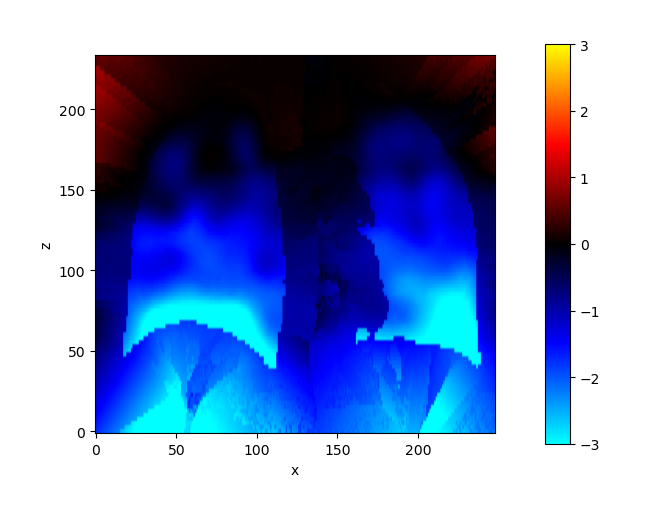

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


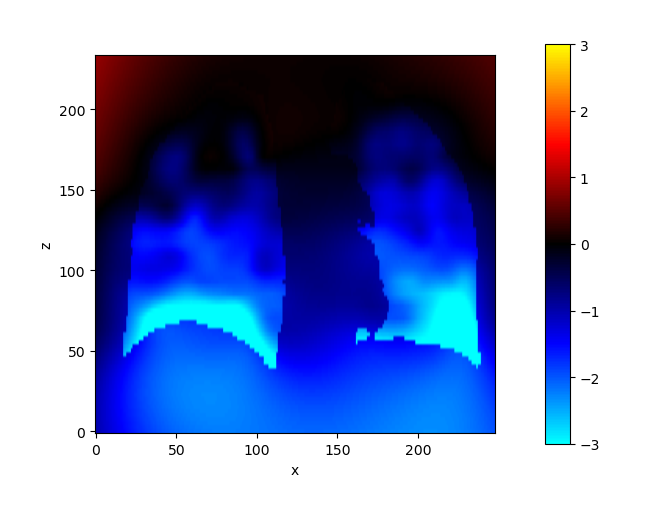

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [64]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_interp) * ee_overlay, x='x', y='z', vmin=-3, vmax=3).update_index(y=140, component=2)
project.visual.XArrayViewer(reg_disp_image * ee_overlay, x='x', y='z', vmin=-3, vmax=3).update_index(y=140, component=2)

## Physical model

Conservation of momentum
$$
    \nabla\cdot\sigma + \mathbf{b} = 0
$$

Isotropic linear elasticity
$$
    \sigma = 2 \mu \epsilon + \lambda \operatorname{tr}(\epsilon) \mathbf{I}
$$

Strain-displacement relation
$$
    \epsilon = \tfrac{1}{2} \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right)
$$

Weak formulation
$$
\begin{align*}
    \nabla\cdot\sigma + \mathbf{b} &= 0 \\
    -\nabla\cdot\sigma &= \mathbf{b} \\
    -\int_\Omega (\nabla\cdot\sigma)\cdot\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} \\
    \int_\Omega \sigma\cdot\nabla\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} (\sigma\cdot\mathbf{n})\cdot\mathbf{v} \,d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u})\cdot\epsilon(\mathbf{v}) \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} \mathbf{t}\cdot\mathbf{v} \,d\mathbf{s}
\end{align*}
$$



In [85]:
%%time
class PDESolver(torch_fenics.FEniCSModule):

    def __init__(self, mesh):
        super().__init__()
        
        # initialize function spaces
        self.scalar_space = fe.FunctionSpace(mesh, 'P', 1)
        self.vector_space = fe.VectorFunctionSpace(mesh, 'P', 1)
            
    def input_templates(self):
        return (
            fa.Function(self.vector_space), # u_true
            fa.Function(self.scalar_space), # mu
        )

    def solve(self, u_true, mu):

        # define physical parameters
        g   = 9.8 # gravitational acceleration (m/s^2)
        rho = 1.0 # mass density (kg/m^3)
        nu  = 0.4 # Poisson's ratio (unitless)
    
        lam = 2*mu*nu/(1 - 2*nu) # Lame's first parameter (Pa)

        # set displacement boundary condition
        u_bc = fa.DirichletBC(self.vector_space, u_true, 'on_boundary')

        # body force and traction
        b = fa.Constant((0, 0, -rho * g))
        t = fa.Constant((0, 0, 0))

        # define stress and strain
        def epsilon(u):
            return (fe.grad(u) + fe.grad(u).T) / 2

        def sigma(u):
            I = fe.Identity(u.geometric_dimension())
            return lam * fe.div(u) * I + 2 * mu * epsilon(u)

        # weak PDE formulation
        u = fe.TrialFunction(self.vector_space)
        v = fe.TestFunction(self.vector_space)

        a = fe.inner(sigma(u), epsilon(v)) * fe.dx
        L = fe.dot(b, v) * fe.dx + fe.dot(t, v) * fe.ds

        # solve for displacement
        u_pred = fa.Function(self.vector_space)
        fa.solve(a == L, u_pred, u_bc)

        return u_pred

pde_solver = PDESolver(ee_lung_fe_mesh)

u_tensor = torch.as_tensor(reg_disp_image.values)
mu_tensor = torch.randn(case.shape, dtype=torch.float64)*0 + 3e3

u_func_dofs = project.interpolate.image_to_dofs(u_tensor, case.resolution, pde_solver.vector_space)
u_func_dofs.requires_grad = False

mu_func_dofs = project.interpolate.image_to_dofs(mu_tensor, case.resolution, pde_solver.scalar_space)
mu_func_dofs.requires_grad = True

u_pred_func_dofs = pde_solver.forward(u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0))[0]

CPU times: user 6.27 s, sys: 4.61 s, total: 10.9 s
Wall time: 3.57 s


In [86]:
# compute PDE-constrained loss and mu sensitivity

L = F.mse_loss(u_pred_func_dofs, u_func_dofs)
print(L)
L.backward()
print(u_func_dofs.grad)
print(mu_func_dofs.grad)

tensor(0.1160, dtype=torch.float64, grad_fn=<MseLossBackward0>)
None
tensor([ 0.0000e+00, -1.2160e-10,  0.0000e+00,  ..., -1.2329e-09,
        -1.1237e-09, -5.7758e-10], dtype=torch.float64)


In [92]:
# PDE-constrained optimization

mu_func_dofs.requires_grad = True
optimizer = torch.optim.Adam([mu_func_dofs], lr=1e1)

for i in range(1000):
    optimizer.zero_grad()

    u_pred_func_dofs = pde_solver.forward(u_func_dofs.unsqueeze(0), mu_func_dofs.unsqueeze(0))[0]

    loss = F.mse_loss(u_pred_func_dofs, u_func_dofs)
    print((i+1), loss.item())

    loss.backward()
    optimizer.step()


1 0.09512464671304725
2 0.09499202431511612
3 0.09485961246031742
4 0.09472741260256376
5 0.0945954261242732
6 0.094463654330993
7 0.0943320984463778
8 0.09420075960756741
9 0.09406963886099101
10 0.09393873715862512
11 0.0938080553547252
12 0.09367759420304297
13 0.09354735435454194
14 0.0934173363556088
15 0.09328754064676556
16 0.09315796756186479
17 0.09302861732776452
18 0.09289949006445898
19 0.09277058578564835
20 0.0926419043997221
21 0.09251344571112462
22 0.0923852094220835
23 0.09225719513465593
24 0.09212940235307224
25 0.09200183048633646
26 0.09187447885105492
27 0.09174734667445493
28 0.09162043309756766
29 0.09149373717853808
30 0.09136725789603574
31 0.09124099415273453
32 0.09111494477884093
33 0.09098910853563674
34 0.0908634841190238
35 0.09073807016304052
36 0.09061286524334117
37 0.09048786788061111
38 0.09036307654391271
39 0.0902384896539461
40 0.09011410558620955
41 0.08998992267406086
42 0.0898659392116608
43 0.08974215345680471
44 0.08961856363362931
45 0.089

349 0.05875225395854723
350 0.05869546277526666
351 0.058638878594373306
352 0.05858252454058176
353 0.05852643794532075
354 0.05847066003916985
355 0.058415222627418335
356 0.05836013833610815
357 0.058305403439124444
358 0.058251015343318245
359 0.05819699026598602
360 0.05814336391413634
361 0.05809017839097849
362 0.05803746482293847
363 0.057985214308387975
364 0.05793335135059627
365 0.05788178636305777
366 0.057830507878109956
367 0.057779509068053646
368 0.05772880633527781
369 0.05767846305763813
370 0.057628372401787684
371 0.05757846873871476
372 0.05752883432504374
373 0.057479436550947234
374 0.05743030931743956
375 0.057381399917015144
376 0.0573326672168344
377 0.05728411786923674
378 0.05723581878575428
379 0.05718769229356767
380 0.05713975207838385
381 0.057092003697285267
382 0.057044519348223924
383 0.0569979357085548
384 0.056955214003700905
385 0.05691068680843517
386 0.05686638820490181
387 0.056820118705784586
388 0.056773514858524325
389 0.0567262378062048
390 

688 0.047838998765871533
689 0.04781485946700965
690 0.04779037481261545
691 0.047766067777152976
692 0.047740931034759945
693 0.0477161761814829
694 0.047690661199933704
695 0.04766618941128935
696 0.047645246279157186
697 0.04761849420140232
698 0.0476000666184151
699 0.04757967204665799
700 0.04755737786682825
701 0.04753479019401449
702 0.047512453140174375
703 0.047490144630622025
704 0.04746789843423478
705 0.04744591867057206
706 0.047424152629239845
707 0.04740224469656729
708 0.047380043984420646
709 0.047357843269569676
710 0.047335767015932784
711 0.047313580741801885
712 0.047291102571126016
713 0.04726848072251211
714 0.04724602146181465
715 0.047223700276329085
716 0.04720110841048587
717 0.04717850932266429
718 0.0471561311881035
719 0.047133543285586076
720 0.04711110389133333
721 0.047089013623925056
722 0.04706705417042288
723 0.04704492136063555
724 0.04702709466659324
725 0.047011947393364874
726 0.04698554355794308
727 0.04696485780924192
728 0.046944396454479405
7

In [93]:
%%time
u_pred_image = project.interpolate.dofs_to_image(u_pred_func_dofs, pde_solver.vector_space, case.shape, case.resolution)

CPU times: user 3min 10s, sys: 184 ms, total: 3min 10s
Wall time: 3min 15s


In [94]:
%%time
mu_pred_image = project.interpolate.dofs_to_image(mu_func_dofs, pde_solver.scalar_space, case.shape, case.resolution)

CPU times: user 3min 3s, sys: 111 ms, total: 3min 3s
Wall time: 3min 9s


<IPython.core.display.Javascript object>


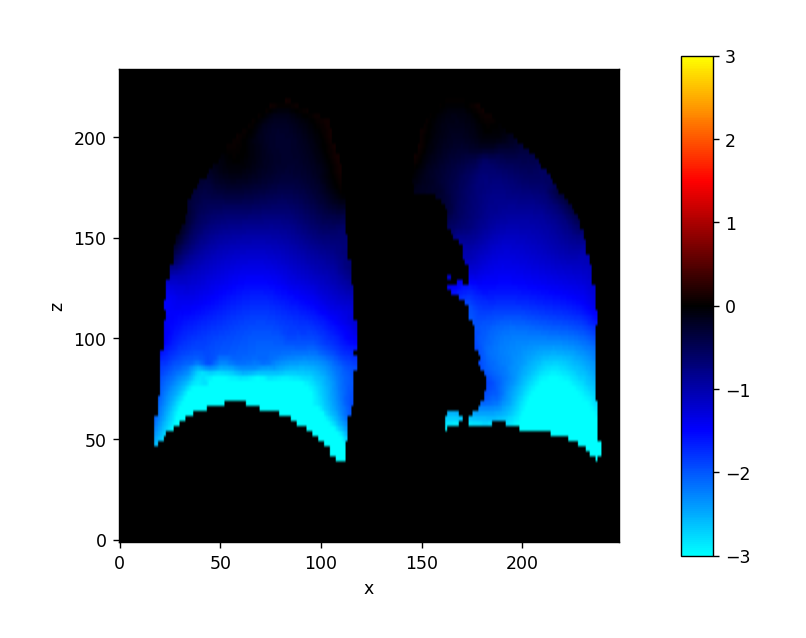

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


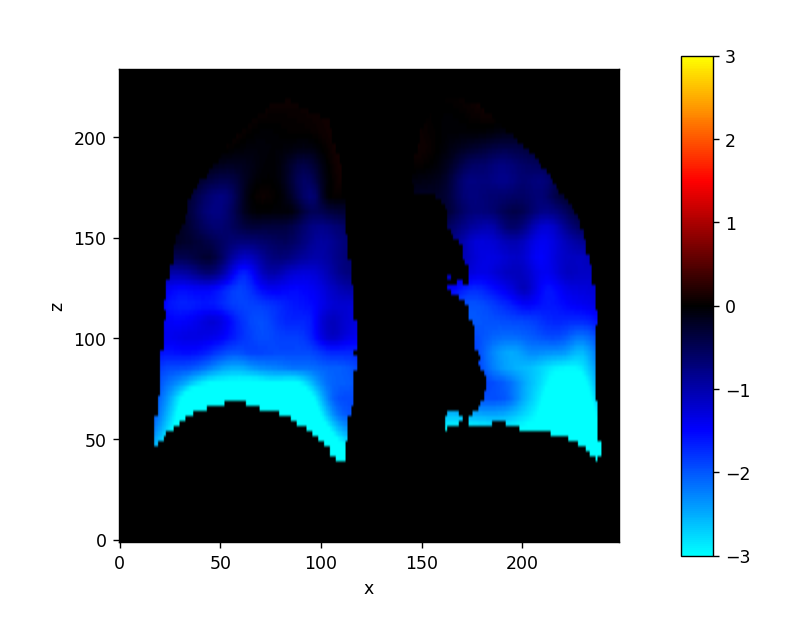

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

<IPython.core.display.Javascript object>


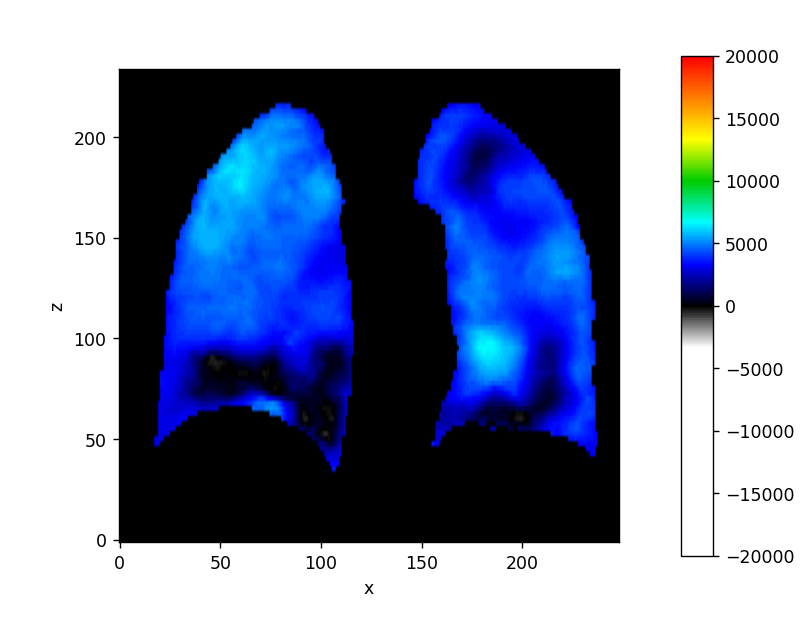

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [95]:
project.visual.XArrayViewer((reg_disp_image * 0 + u_pred_image) * ee_lung_mask, x='x', y='z', vmin=-3, vmax=3).update_index(y=140, component=2)
project.visual.XArrayViewer(reg_disp_image * ee_lung_mask, x='x', y='z', vmin=-3, vmax=3).update_index(y=140, component=2)
project.visual.view(mu_pred_image * ee_lung_mask, x='x', y='z', cmap=project.visual.mre_color_map(), vmin=-2e4, vmax=2e4).update_index(y=140)

In [ ]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_func(f):

    mesh = f.function_space().mesh()

    vertices = mesh.coordinates()
    n_vertices = mesh.num_vertices()
    values = f.compute_vertex_values(mesh)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d', aspect='equal')

    X = [vertices[:,i] for i in range(3)]
    U = [values[i * n_vertices:(i + 1) * n_vertices] for i in range(3)]
    
    print(np.mean(np.linalg.norm(U, axis=1), axis=0))
       
    args = X + U
    ax.quiver(*args)
    
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

plot_func(disp_fe_func)

In [ ]:
project.visual.view((reg_disp_image * 0 + sim_disp_image) * ee_lung_mask, x='x', y='z')